In [23]:
a_clase_1 = [
           [(450,1150),(2050,2200)], #1
           [(1000,1250),(2150,2410)], 
           [(1050,1150),(2410,2510)], #esta rarisimo
           [(990,1290),(2100,2400)],
           [(1080,1400),(1950,2220)], #5
           [(1240,1500),(2100,2350)],
           [(1100,1300),(2370,2510)],
           [(900,1100),(2090,2470)],
           [(800,1240),(2150,2730)],
           [(910,1250),(1970,2300)], #10
           [(500,1070),(2100,2300)],
           [(590,1120),(2100,2300)],
           [(870,970),(1990,2200)],
           [(850,1200),(2160,2400)],
           [(1170,1460),(2030,2270)],#15
           [(760,1030),(1990,2420)],
           [(870,1450),(1900,2190)],
           [(850,1050),(1900,2250)],
           [(560,1270),(2000,2590)],
           [(240,1150),(2040,2720)],#20
           ]
a_clase_2 = [
           [(470,1900)],#1
           [(630,1750)],
           [(400,1800)],
           [(600,1850)],
           [(570,1850)],#5
           [(730,1950)],
           [(600,1700)],
           [(620,1600)],
           [(560,1630)],
           [(700,1780)],#10
           [(750,1800)],
           [(850,1950)],
           [(700,1830)],
           [(640,1830)],
           [(700,1900)],#15
           [(650,1580)],
           [(380,1780)],
           [(550,1850)],
           [(700,1800)],
           [(600,1700)],#20
          ]
a_clase_3 = [
           [(440,1700)],#1
           [(550,1580)],
           [(820,1800)],
           [(700,1900)],
           [(600,1650)],#5
           [(540,1600)],
           [(360,1730)],
           [(600,1790)],
           [(880,1800)],
           [(550,1930)],#10
           [(900,1930)],
           [(600,1930)],
           [(640,1900)],
           [(650,1830)],
           [(1000,1990)],#15
           [(640,1700)],
           [(630,1750)],
           [(630,1950)],
           [(740,1970)],
           [(530,1670)],#20
          ]
a_clase_4 = [
           [(550,800),(1020,1200),(1400,1530)],#1
           [(530,800),(1000,1100),(1400,1550)],
           [(500,680),(750,1100),(1420,1790)],
           [(690,850),(1240,1400),(1620,1840)],
           [(300,670),(880,1240),(1550,1780)],#5
           [(570,700),(1050,1250),(1550,1990)],
           [(550,850),(1200,1450),(1700,1800)],
           [(650,970),(1140,1340),(1600,1900)],
           [(300,500),(700,900),(1450,1750)],
           [(550,800),(1050,1350),(1570,1750)],#10
           [(300,500),(900,1150),(1550,1850)],
           [(550,800),(1150,1250),(1600,1900)],
           [(600,890),(1150,1380),(1600,1900)],
           [(400,600),(1000,1250),(1400,1700)],
           [(550,730),(1100,1350),(1450,1850)],#15
           [(570,730),(1040,1280),(1700,1900)],
           [(620,900),(1150,1430),(1600,1780)],
           [(650,830),(1050,1230),(1540,1700)],
           [(540,750),(1050,1200),(1700,1880)],
           [(720,850),(1230,1400),(1650,1850)],#20
]
classes = [a_clase_1, a_clase_2, a_clase_3, a_clase_4]

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_SOURCE = "raw_csi/betty/"
def _read_csi_next(pcapfile, csi_size):
    """
    Note: Designed for internal use only.
    Parameters
    ----------
        pcapfile : File Object
        csi_size : Expected length of CSI in bytes. NFFT * 4
    """

    # Read Frame Size
    pcapfile.seek(8, os.SEEK_CUR)
    frame_size = int.from_bytes(
        pcapfile.read(4),
        byteorder='little',
        signed=False
    )

    # Skip some stuff
    pcapfile.seek(56, os.SEEK_CUR)

    # Read CSI data
    pcapfile.seek(8, os.SEEK_CUR)
    csi = np.frombuffer(
        pcapfile.read(csi_size),
        dtype=np.int16,
        count=int(csi_size / 2)
    )

    # Skip any zero-padding
    pcapfile.seek((frame_size - csi_size - 60), os.SEEK_CUR)

    return csi


def read_csi(pcap_file_path):
    """
    Read CSI data from PCAP file.
    Supports only 40MHz bandwidth,
    and only one Mac ID. You have
    to remove null subcarriers
    yourself.
    Parameters
    ----------
        pcap_file_path : str
    """

    bandwidth = 80

    NFFT = int(bandwidth * 3.2)  # Number of channels in FFT
    chunksize = 1024

    csi = np.zeros((chunksize, NFFT * 2), dtype='int16')

    with open(pcap_file_path, 'rb') as pcapfile:
        filesize = os.stat(pcap_file_path).st_size
        pcapfile.seek(24, os.SEEK_SET)

        npackets = 0
        while pcapfile.tell() < filesize:
            if not (npackets % chunksize):
                csi = np.vstack((csi, np.zeros((chunksize, NFFT * 2), dtype='int16')))

            csi[npackets] = _read_csi_next(pcapfile, NFFT * 4)

            npackets += 1

    # Convert CSI complex numbers to Magnitude.
    csi_converted = np.abs(
        np.fft.fftshift(csi[:npackets, ::2] + 1.j * csi[:npackets, 1::2], axes=(1,))
    )

    return csi_converted

def get_data_class():
    dataset = pd.DataFrame()
    target = []
    class_names = ['a_human', 'exercise', 'girando', 'sitting']
    for index, class_name in enumerate(class_names):
        for number in range(20):
          n = number + 1
          csi = pd.DataFrame(read_csi(DATA_SOURCE+class_name+str(n)+'.pcap'))
          for activities in classes[index]:
            for activity in activities:
              start, end = activity
              csi = csi[start: end+1]
              dataset = dataset.append(csi.mean(), ignore_index=True)
          target = target + [index + 1] * len(activities)
          # Deleting rows with NaN values
          dataset.dropna(inplace=True)
          dataset = pd.concat([dataset, csi], axis=0)
    return dataset, target

if __name__ == '__main__':

    # 80 MHz
    nullsubcarriers  = np.array([x+128 for x in [-128, -127, -126, -125, -124, -123, -1, 0, 1, 123, 124, 125, 126, 127]])
    pilotsubcarriers = np.array([x+128 for x in [-103, -75, -39, -11, 11, 39, 75, 103]])

    
    csi, target = get_data_class()

    csi = csi.drop(columns=nullsubcarriers)
    csi = csi.drop(columns=pilotsubcarriers)
    

    # I have not tested this on 80 MHz data yet. It should work, but I can't guarantee it.
    #cc = csi.to_numpy()

    #plt.figure(figsize=(30, 30))
    #plt.imshow(np.transpose(cc))
    #plt.ylabel('value')
    #plt.show()
    #normalized = preprocessing.normalize(cc) 
    csi.to_csv('dataset.csv')
    pd.DataFrame(data=target).to_csv('targets.csv')

In [43]:
X = csi.to_numpy()
Y = np.array(target).reshape((-1,1))
samples, feature_size = X.shape

In [44]:
print(X.shape)
print(Y.shape)

(140, 234)
(140, 1)


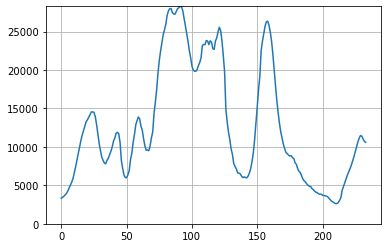

In [45]:
# check variances:
variances = np.zeros((feature_size,1))
for i_idx in range(0,feature_size):
    tmp_i = X[:,i_idx]
    mean_i = np.mean(tmp_i)
    var_ii = np.mean(np.multiply((tmp_i - mean_i), (tmp_i - mean_i)))
    variances[i_idx] = var_ii

fig = plt.figure()
ax = plt.axes()
plt.plot(variances)
plt.ylim(0, np.amax(variances))
plt.grid()
plt.show()

In [46]:
X_normalized = np.zeros(X.shape)
for i_idx in range(0,feature_size):
    tmp_i = X[:,i_idx]
    mean_i = np.mean(tmp_i)
    var_ii = np.mean(np.multiply((tmp_i - mean_i), (tmp_i - mean_i)))
    sigma_ii = np.sqrt(var_ii)
    X_normalized[:,i_idx] = np.divide(tmp_i - mean_i,sigma_ii)

In [47]:
# check variance and covariances:
#X_normalized = X


In [48]:
covariance = np.cov(X_normalized,rowvar=False)
print (covariance)

[[ 1.00719424  1.00495262  1.00336907 ... -0.29208106 -0.27684079
  -0.26589834]
 [ 1.00495262  1.00719424  1.00635641 ... -0.31421859 -0.30032061
  -0.29113054]
 [ 1.00336907  1.00635641  1.00719424 ... -0.29842312 -0.28443429
  -0.2752354 ]
 ...
 [-0.29208106 -0.31421859 -0.29842312 ...  1.00719424  1.00600606
   1.00190046]
 [-0.27684079 -0.30032061 -0.28443429 ...  1.00600606  1.00719424
   1.00563496]
 [-0.26589834 -0.29113054 -0.2752354  ...  1.00190046  1.00563496
   1.00719424]]


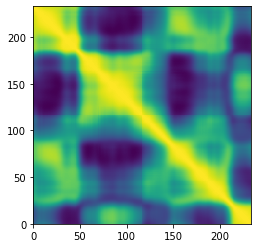

In [49]:
fig = plt.figure()
ax = plt.axes()
plt.imshow(covariance, extent=[0, feature_size-1, 0, feature_size-1])
plt.show()